In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from function import *
from sklearn.preprocessing import StandardScaler
import numpy as np
import skfuzzy as fuzz
import seaborn as sns
sns.set_style("darkgrid")

# Sklearn for data import and scalers
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

#interactive plot
# Please consult information to update plotly.offline 
# e.g. https://medium.com/plotly/plotly-py-4-0-is-here-offline-only-express-first-displayable-anywhere-fc444e5659ee
import plotly
from plotly.offline import plot
from plotly.graph_objs import *

In [16]:
# load data
file_path = 'forestfires.csv'
df = pd.read_csv(file_path)
small_data = df[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'area']]
for col in small_data.columns:
    small_data.loc[:, col] = normalization_zscore(small_data[col])

print(small_data.shape)

(517, 7)


##### a) Visualize the data over these features in 2D/3D PC plane (by sklearn package)

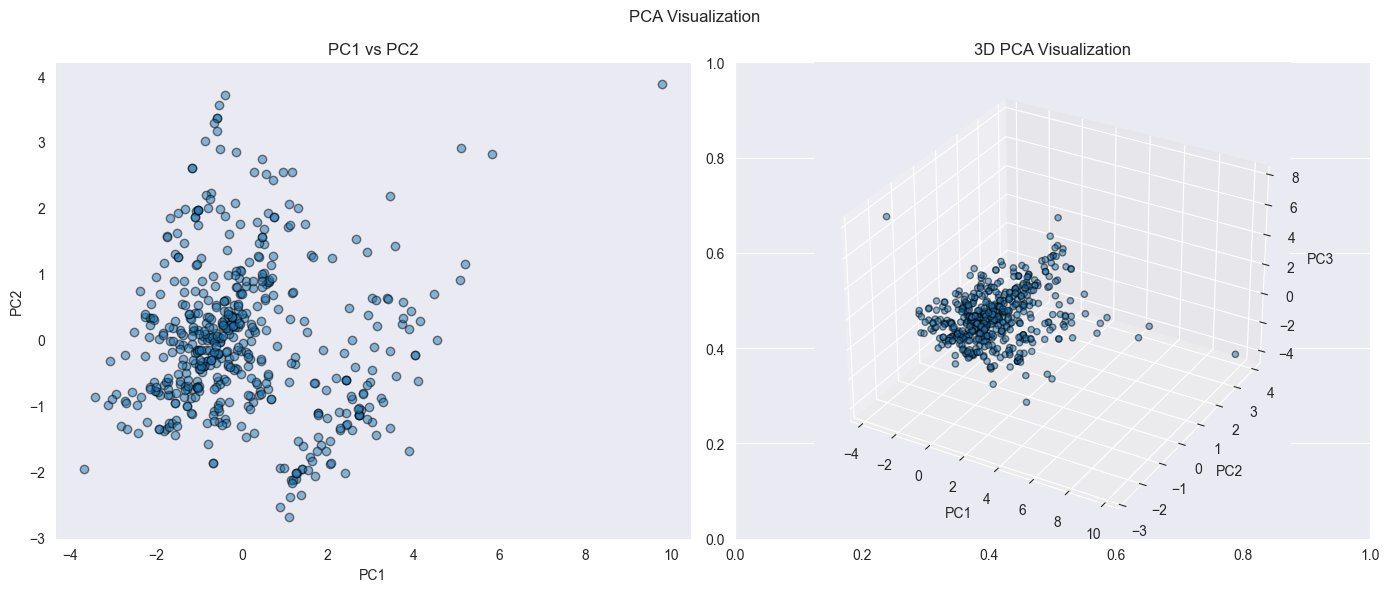

In [9]:
from sklearn.decomposition import PCA

# PCA
def apply_pca(data, n_components=3):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
    return pca_df

pca_df = apply_pca(small_data)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': None})
fig.suptitle('PCA Visualization')

# 2D Scatter Plot (PC1 vs PC2)
axes[0].scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, edgecolor='k')
axes[0].set_title('PC1 vs PC2')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid()

# 3D Scatter Plot (PC1 vs PC2 vs PC3)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], alpha=0.5, edgecolor='k')
ax.set_title('3D PCA Visualization')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.tight_layout()
plt.show()


##### PCA with svd 

In [37]:
# Center the Data 
x_values = small_data[['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH']]
y_values = small_data[['area']]

# Normalize data by Range
x_norm = normalization_range(x_values)
# Normalize data by Z-score
x_zscore = normalization_zscore(x_values)

def caulate_eingenvalues_eingenvectors(x_norm):
    # Covariance matrix
    covmatrix = np.cov(x_norm.T)

    # Obtain the eingenvalues and eingenvectors of covariance matrix
    e, v = np.linalg.eig(covmatrix)

    # order descendingly by largest eigenvalue
    order = np.argsort((np.argsort(e) * -1))
    e = e[order]
    v = v[:,order]
    return e, v

# Calculate eigenvalues and eigenvectors for the range normalized data
e_Range, v_Range = caulate_eingenvalues_eingenvectors(x_norm)
print('Eigenvectors \n%s' %e_Range)
print('\nEigenvalues \n%s' %v_Range)

# Calculate eigenvalues and eigenvectors for the Z-score normalized data
e_z, v_z = caulate_eingenvalues_eingenvectors(x_zscore)
print('Eigenvectors \n%s' %e_z)
print('\nEigenvalues \n%s' %v_z)


Eigenvectors 
[0.0205276  0.04926616 0.12826027 0.00238174 0.00637407 0.00992254]

Eigenvalues 
[[-0.09793713 -0.08637777 -0.0889681   0.82597338 -0.54048537 -0.02598883]
 [-0.71039903  0.21854069 -0.51692797 -0.05960493  0.10735004 -0.40654875]
 [ 0.61424557  0.18274372 -0.76584481 -0.02163722 -0.04700236 -0.01055702]
 [-0.1549828  -0.06374619 -0.07841812 -0.5447423  -0.7912623   0.20718869]
 [-0.26086135 -0.49404804 -0.35473267  0.07138297  0.26006979  0.6995004 ]
 [-0.12796718  0.81439336  0.07979488  0.10912083  0.02024835  0.54927524]]
Eigenvectors 
[1.27749777 2.80929372 0.89609298 0.47399992 0.23260356 0.31051206]

Eigenvalues 
[[ 1.65522612e-01  4.36893094e-01  4.11268196e-01 -7.46849424e-01
   2.32146289e-01  3.01529322e-02]
 [-4.82245795e-01  4.35182034e-01 -1.19558087e-01 -4.09198591e-02
  -4.70779571e-01  5.83484031e-01]
 [-4.08948359e-01  4.30266161e-01 -3.32492642e-01 -5.16907286e-02
  -4.69002596e-04 -7.31032668e-01]
 [ 1.03580236e-01  3.79312589e-01  6.83328938e-01  5.4

In [47]:
def pca_transform(x_norm, v):
    # generate PCA component space (PCA scores)
    pc = np.dot(x_norm, v)
    # set data to a Pandas Dataframa to ease plotting
    names = ["PC_"+str(x+1) for x in range(pc.shape[1])]
    names.append('Area')
    data_pca = pd.DataFrame(data= np.c_[pc, y_values], 
                        columns=names)
    data_pca['Area'] = data_pca['Area'].astype(int)
    return pc, data_pca

# PCA transformation
pc_Range, data_pca_Range = pca_transform(x_norm, v_Range)
pc_z, data_pca_z = pca_transform(x_zscore, v_z)


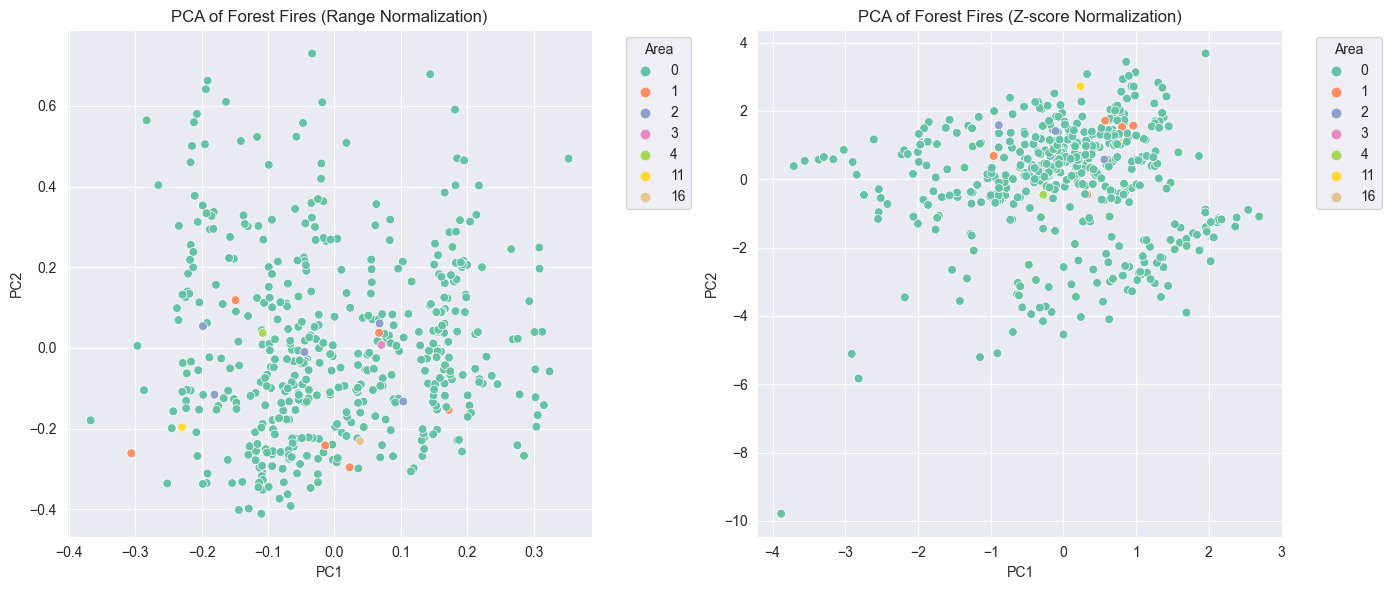

In [54]:
# Plotting PCA results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First PCA plot (Range-normalized data)
sns.scatterplot(data=data_pca_Range, 
                x='PC_1', 
                y='PC_2', 
                hue='Area',
                palette='Set2', 
                alpha=1, 
                s=40, 
                ax=axes[0])

axes[0].set_title('PCA of Forest Fires (Range Normalization)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left')

# Second PCA plot (Z-score normalized data)
sns.scatterplot(data=data_pca_z, 
                x='PC_1', 
                y='PC_2', 
                hue='Area', 
                palette='Set2',
                alpha=1, 
                s=40, 
                ax=axes[1])

axes[1].set_title('PCA of Forest Fires (Z-score Normalization)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(title='Area', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
## Quality of PC 

def quality_pc(e):
        totVar = sum(e)       #Total variability of the Data
        var_exp = [(i / totVar)*100 for i in sorted(e, reverse=True)]
        cum_var_exp = np.cumsum(var_exp)

        trace1 = Bar(
                x=['PC %s' %i for i in range(1,5)],
                y=var_exp,
                name='Exp Var',
                showlegend=False)

        trace2 = Scatter(
                x=['PC %s' %i for i in range(1,5)], 
                y=cum_var_exp,
                name='Cum. Exp Var')

        data = Data([trace1, trace2])

        layout=Layout(
                yaxis=YAxis(title='Explained variance in percent'),
                title='Explained variance by different principal components')

        fig = Figure(data=data, layout=layout)
        plot(fig)

quality_pc(e_Range)
quality_pc(e_z)